In [13]:
%matplotlib inline

In [14]:
import tensorflow as tf
import tensorflow_models as tfm

from official.vision.configs import maskrcnn as exp_cfg
from official.core import config_definitions as cfg
from official.core import exp_factory
from official.vision.tasks import maskrcnn
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder
from official.vision.serving import export_saved_model_lib
from official.vision.configs import backbones as backbones_cfg
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import numpy as np
from official.vision.utils.object_detection import visualization_utils
import time
from custom_utils import send_pushover_notification, intercept_stdout
from functools import partial
from tfm_configs import *
import re
import tensorflow_datasets as tfds
import pandas as pd

In [15]:
IMAGE_SIZE = (640, 640)
BATCH_SIZE = 4
TFDS_NAME = 'leaf_instance_dataset'
INPUT_PATH = "/home/stefan.steinheber/tensorflow_datasets/leaf_instance_dataset/1.0.0/"
MODEL = "retinanet_resnet_fpn"
MODEL_DIR = "out/" + MODEL
START = time.time()

In [16]:
exp_config = retinanet_resnet_fpn(INPUT_PATH)

In [17]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices('GPU')]

if len(logical_device_names) == 0:
    logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print("Created distribution Strategy on Device", logical_device_names[0])

Created distribution Strategy on Device /device:GPU:0


In [18]:
def show_batch(raw_records):
    tf_ex_decoder = TfExampleDecoder(include_mask=True)
    plt.figure(figsize=(20, 20))
    use_normalized_coordinates=True
    min_score_thresh = 0.30
    for i, serialized_example in enumerate(raw_records):
        plt.subplot(1, 3, i + 1)
        decoded_tensors = tf_ex_decoder.decode(serialized_example)
        image = decoded_tensors['image'].numpy().astype('uint8')
        scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
        visualization_utils.visualize_boxes_and_labels_on_image_array(
            image,
            decoded_tensors['groundtruth_boxes'].numpy(),
            decoded_tensors['groundtruth_classes'].numpy().astype('int'),
            scores,
            category_index={
                1: {
                    'id': 1,
                    'name': 'leaf',
                },
            },
            use_normalized_coordinates=use_normalized_coordinates,
            min_score_thresh=min_score_thresh,
            instance_masks=decoded_tensors['groundtruth_instance_masks'].numpy().astype('uint8'),
            line_thickness=4)

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image-{i+1}")
    plt.show()
    #plt.savefig("out/fig.png")

In [19]:
with distribution_strategy.scope():
    task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=MODEL_DIR)

2024-07-22 16:54:45.877447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


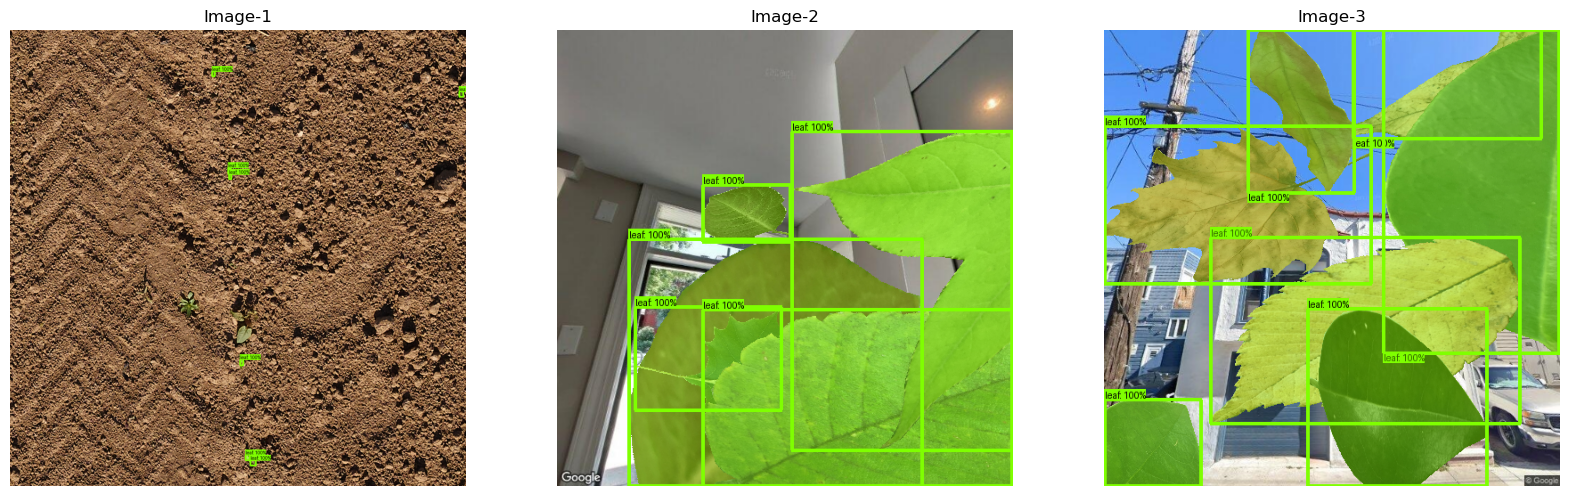

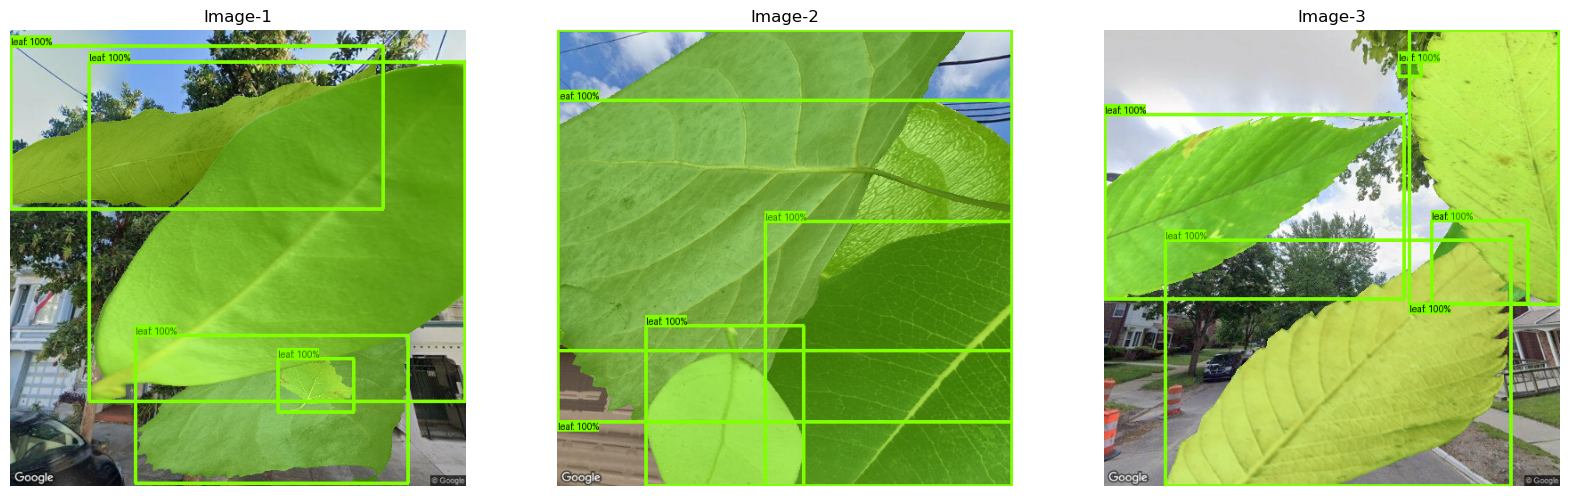

In [20]:
buffer_size = 100
num_of_examples = 3

train_tfrecords = tf.io.gfile.glob(exp_config.task.train_data.input_path)
raw_records = tf.data.TFRecordDataset(train_tfrecords).shuffle(buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records)

In [21]:
def send_notification(text):
    if "loss" not in text or 'eval' not in text:
        return
    step = re.search(r"step:.*?(\d+).*?\|", text)
    step = step.group(1)
    losses = re.findall(r"'(.*)_loss':.*?(\d+\.\d+)", text)
    losses.reverse()
    msg = f"Step #{step}:" + ' - '.join([f"{name} Loss: {value}" for name, value in losses])
    send_pushover_notification(msg, title="Training Losses", priority=-1)

In [22]:
data = []
def tfm_log(text):
    if "loss" not in text or 'eval' not in text:
        return
    step = re.search(r"step:.*?(\d+).*?\|", text)
    step = step.group(1)
    losses = re.findall(r"'(.*)_loss':.*?(\d+\.\d+)", text)
    metrics = {name: value for name, value in losses}
    metrics.update({'step': step})
    
    data.append(metrics)

    df = pd.DataFrame(data)
    os.makedirs(f"metrics/{MODEL}", exist_ok=True)
    df.to_csv(f"metrics/{MODEL}/metrics_{START}.csv", index=False)

In [23]:
send_pushover_notification("Starting Training", "Tensorflow Models")

with intercept_stdout(tfm_log):
    model, eval_logs = tfm.core.train_lib.run_experiment(
        distribution_strategy=distribution_strategy,
        task=task,
        mode='train_and_eval',
        params=exp_config,
        model_dir=MODEL_DIR,
        run_post_eval=True)

restoring or initializing model...
restored model from out/retinanet_resnet_fpn/ckpt-242200.
restored from checkpoint: out/retinanet_resnet_fpn/ckpt-242200
train | step:  242200 | training until step 243200...
train | step:  243200 | steps/sec:    4.2 | output: 
    {'box_loss': 0.0021702508,
     'cls_loss': 0.16944669,
     'learning_rate': 0.0012,
     'model_loss': 0.27795917,
     'total_loss': 0.3870706,
     'training_loss': 0.3870706}
saved checkpoint to out/retinanet_resnet_fpn/ckpt-243200.
 eval | step:  243200 | running 278 steps of evaluation...


2024-07-22 16:59:08.977697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-22 16:59:08.977837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-22 16:59:08.978478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 eval | step:  243200 | steps/sec:   27.2 | eval time:   10.2 sec | output: 
    {'box_loss': 0.003472145,
     'cls_loss': 0.22643423,
     'model_loss': 0.4000415,
     'steps_per_second': 27.220278007547755,
     'total_loss': 0.509061,
     'validation_loss': 0.509061}

OSError: Cannot save file into a non-existent directory: 'metrics/retinanet_resnet_fpn'

In [ ]:
send_pushover_notification("Finished Training", "Tensorflow Models")

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[IMAGE_SIZE[1], IMAGE_SIZE[0]],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(MODEL_DIR),
    export_dir=f'{MODEL_DIR}/final')